# [AI Innovation Square 릴레이 온라인 특강: 시각] 


##  5. Transfer Learning

인공지능의 미래
- Andrew Ng : Transfer Learning
- Yann LeCun: Unsupervised Learning


### Transfer Learning
- 기존에 학습한 모델을 가져와서 새로운 모델을 만듦
    - 기존의 학습된 모델의 가중치가 변함
- 단순한 feature에서 점점더 구체적인 추상화된 feature 추출해서 영상에서는 잘 됨
    - Fully connected 교체
        - 데이터가 적고 유사한 경우
        - 이미 학습된 데이터의 feature map 그대로 사용
        - 재훈련 불필요
            - include_top=False
            - trainalbe =False
    - Feature Extrat 일부 교체(미세 조정)
        - 데이터가 많고 유사한 경우
    - 구조 
        - 데이터가 많고 상이한 경우

### Incremental Learning
- 기존의 모델에 추가해서 학습
- eg. Knowledge Distillation 지식 증류 기술 :선생님 모델이 제자에게 필요한 액기스만

> 피터노빅: 데이터가 알고리즘보다 중요하다


#### 경량화
- TF Lite: 모바일, IoT용 으로 학습 용도가 아님
- ETRI 경량 딥러닝 기술 동향.pdf 참고
- feasibility 테스트 이후 경량화
- 단순화, 정확도 낮음



## 1. tf.keras.applications


- [전이학습 및 미세조정 참고](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko)
- 개, 고양이 모델
    - imagenet에 이미 개,고양이 데이터 학습 시켰어서 높은 정확도
    - 데이터가 유사하고 적은 경우
- binary classificaiton ( 개1, 고양이 0)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

tensorflow_datasets
- tf.data.Dataset 오브젝트를 리턴
    - prefetch 사용 가능
- holdout

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

### imbalanced dataset
- 과적합 발생 가능
- 층화계층법(stratified sampling)
- data shift : 학습, 검정 데이터 비율 상이
- 클래스 비율에 맞춰 나누어

In [ ]:
import mglearn

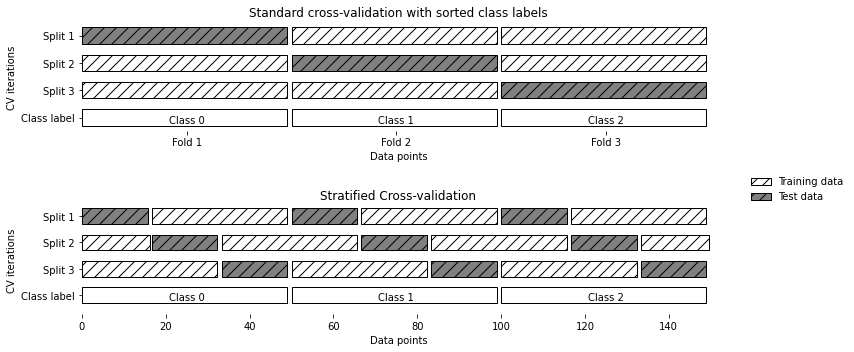

In [ ]:
mglearn.plot_cross_validation.plot_stratified_cross_validation()

In [ ]:
IMG_SIZE = 160 # 모든 이미지는 160x160으로 크기가 조정됩니다

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


In [ ]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

#### 1. Fully connected 교체

In [ ]:
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 사전 훈련된 모델 MobileNet V2에서 기본 모델을 생성합니다.
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
base_model.trainable = False
# 기본 모델 아키텍처를 살펴봅니다.
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1)
])

#### 2. Finetuning 

In [ ]:
base_model.trainable = True

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

---
## 2. Tensorflow Hub
- https://www.tensorflow.org/hub
    - TensorFlow로 만들어진 모델, 데이터셋 제공
    - 사용 쉬움
    - https://tfhub.dev/s?subtype=module,placeholder
    
- ImageNet 분류기
    - classification: 전체
    - feature_vector: feature extractor  

In [ ]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### headless model
- 분류기 없이 feature extractor만 존재        
- mobilenet_v2 
- image classification
- fine tunable            
- feature_vector

In [3]:
#함수형 패러다임
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [14]:
feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


boosting
- 데이터 랜덤 샘플링해서 모델 생성
- 모델이 잘 분류 못하는 데이터에 가중치 



### Data Augmentation
- Augmentor
    - 외부 라이브러리
- OpenCV : 하나하나 구현해서 만듦
- Scikit-image
- pytorch, TensorFlow에서 제공 

1. tf.keras.preprocessing.image.image.ImageDataGenerator
    -  keras에서 제공
    - GPU 활용 가능
    > Python Iterator, Generator
    - 데이터가 많은 경우 하나식 메모리에 올려서 효율적 관리

### ImageDataGenerator
- 데이터 생성, 정해진 타겟 사이즈 만큼 생성,
- 데이터가 많은 경우 하나식 메모리에 올려서 효율적 관리

generator
1. tuple comp
2. yield

In [ ]:
a=(x for x in range(10))

In [ ]:
next(a)

0

In [ ]:
for i in a:
    print(i)

1
2
3
4
5
6
7
8
9


In [ ]:
dir(a) #__next__

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__next__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'gi_code',
 'gi_frame',
 'gi_running',
 'gi_yieldfrom',
 'send',
 'throw']

In [ ]:
def x():
    yield 1
    yield 2

In [ ]:
t=x()
next(t)

1

- scaling 
    - zero-centered [-1,1]
        - [0,1] 에서 항상 양수이면 zigzag현상 방지
        
        
- 텐서플로 허브와 전이학습 참고: https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub?hl=kozz

In [9]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

228818944/228813984 [==============================] - 1s 0us/step


데이터 구성
- flow_from_dataframe
- flow_from_directory

In [12]:
#해당 directory에서 
IMAGE_SHAPE = (224, 224)

image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


이미지 dataset batch 만큼 나눔

In [13]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


load_files
- 폴더명 기반을 분류
- EDA에 load_files불편

In [1]:
from sklearn.datasets import load_digits, load_files

In [ ]:
data=load_digits()

In [ ]:
dir(data)

['DESCR', 'data', 'feature_names', 'frame', 'images', 'target', 'target_names']

In [ ]:
fi=load_files( ) #파일별로 저장하면 판다스에서 

In [ ]:
# load_files 예시
import pandas as pd
data2=pd.DataFrame(data.data )
data2['target']=data.target
data2['location']='/example'
data2#각 8x8 이미지를 한 줄에 저장

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,target,location
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,/example
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,/example
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,/example
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,/example
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,/example
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,9,/example
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0,/example
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8,/example
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,9,/example


- EDA에 load_files불편

### closure
- ()()
- 함수형 패러다임

In [ ]:
class A:
    def __call__(self):
        print('call')

In [ ]:
a=A()

In [ ]:
a()

call


In [ ]:
def x(m):
  def y(n):
    return m+n
  return y

In [ ]:
x(3)(5)

8

In [ ]:
class A:
    def __init__(self,m):
        self.m=m
    def __call__(self,n):
        self.m+n

In [ ]:
a=A(3)

In [ ]:
a(5)

- feature extractor 부분은 재학습 하지 않음
- feature extractor가 성능이 좋아서 간단한 예측모델 추가

In [15]:
layers=hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" )

In [16]:
dir(layers)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_existing_weight',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_apply_output_shape_if_set',
 '_arguments',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_call_loss_if_trainable',
 '_callable',
 '_callable_losses',
 '_cast_single_input',
 '_check_trainability',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_comput

In [17]:
leyers.weights #260개 layer

NameError: ignored

In [ ]:
len(layers.weights)

In [ ]:
layers.weights[-1] #맨 끝의 레이어는 1차원, Flatten 불필요

모델
- 레이어를 list형식으로 저장
- 각 레이어별 weight 있음

In [ ]:
 model=tf.keras.models.Sequential([
     tf.keras.layers.Conv2D(64,3, input_shape=(20,20,1)),
     tf.keras.layers.Conv2D(64,3),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(1)
 ])

In [ ]:
dir(model)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_los

In [ ]:
model.layers #list

In [ ]:
model.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[-0.07979907, -0.0731146 , -0.07701214,  0.02394105,
            0.0221897 , -0.03268258,  0.01338206, -0.02231006,
            0.06882338, -0.09744184, -0.03877231, -0.08249616,
           -0.07314911, -0.09609616,  0.06468894,  0.10112453,
            0.00788815,  0.05014218, -0.04672886,  0.0630293 ,
            0.04956587, -0.07703051,  0.0913876 , -0.10071765,
            0.07592081,  0.00346789, -0.01722044, -0.07574592,
           -0.0945994 , -0.09701931, -0.08427899,  0.01627202,
            0.07033879,  0.05075298, -0.05185876,  0.07913567,
            0.09940603, -0.09625509,  0.08338954,  0.05682541,
            0.0528347 ,  0.02838726, -0.08840139,  0.09825441,
           -0.02553517, -0.0868928 , -0.00714106, -0.07976864,
           -0.00766323, -0.05434846,  0.0717005 ,  0.04476182,
           -0.09515683, -0.00126482,  0.06715859,  0.01553305,
            0.0305146 ,  0.04485781, -0.0427

In [ ]:
model.layers[0].bias

<tf.Variable 'conv2d/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
model.layers[0].kernel

<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
array([[[[-0.07979907, -0.0731146 , -0.07701214,  0.02394105,
           0.0221897 , -0.03268258,  0.01338206, -0.02231006,
           0.06882338, -0.09744184, -0.03877231, -0.08249616,
          -0.07314911, -0.09609616,  0.06468894,  0.10112453,
           0.00788815,  0.05014218, -0.04672886,  0.0630293 ,
           0.04956587, -0.07703051,  0.0913876 , -0.10071765,
           0.07592081,  0.00346789, -0.01722044, -0.07574592,
          -0.0945994 , -0.09701931, -0.08427899,  0.01627202,
           0.07033879,  0.05075298, -0.05185876,  0.07913567,
           0.09940603, -0.09625509,  0.08338954,  0.05682541,
           0.0528347 ,  0.02838726, -0.08840139,  0.09825441,
          -0.02553517, -0.0868928 , -0.00714106, -0.07976864,
          -0.00766323, -0.05434846,  0.0717005 ,  0.04476182,
          -0.09515683, -0.00126482,  0.06715859,  0.01553305,
           0.0305146 ,  0.04485781, -0.04270015,  0.0761685

In [ ]:
layers.weights[-1]

NameError: name 'layers' is not defined

In [ ]:
layers.weights[-2] #이미 1차원화

### TensorFlow 학습 방법
1. fit
    - 세부적으로 조절 불가
2. fit_generator
    - ImageDataGenerator 
3. train_on_batch
    - batch size만큼 학습
4. train
    - Estimator 
5. with tf.GradientTape
    - 어디에든 사용 가능

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()
    

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

fit 예시

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
data=load_iris()

In [ ]:
iris=pd.DataFrame(data.data,columns=data.feature_names)
iris['target']=data.target
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(16,input_shape=(4,),activation='relu'),
     tf.keras.layers.Dense(16,'relu'),
     tf.keras.layers.Dense(3,'softmax')
])

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

- 15/15 : batch size 10

In [ ]:
model.fit(iris.iloc[:,:-1],iris.target,epochs=5, batch_size=10)

Epoch 1/5
15/15 [==============================] - 0s 2ms/step - loss: 0.9710 - acc: 0.6600
Epoch 2/5
15/15 [==============================] - 0s 5ms/step - loss: 0.8955 - acc: 0.8333
Epoch 3/5
15/15 [==============================] - 0s 4ms/step - loss: 0.8434 - acc: 0.8067
Epoch 4/5
15/15 [==============================] - 0s 5ms/step - loss: 0.8015 - acc: 0.8933
Epoch 5/5
15/15 [==============================] - 0s 5ms/step - loss: 0.7633 - acc: 0.7800


- batch size만큼 실행됨
- 1 epoch 당 train_on_batch 가 여러번 실행

In [ ]:
model.train_on_batch(iris.iloc[:,:-1],iris.target)

[0.7526882886886597, 0.7699999809265137]

- zigzag
테스트 데이터가 작아서
overfitting -> variance